# Mueller Matrix Ellipsometry of a 2D Si gratings
The notebook reproduces the Mueller matrix obtained from ellipsometry measurements across a 
wide range of azimuth angles for 2D Si gratings, adapted from `Comparison of spectroscopic Mueller polarimetry, standard 
scatterometry, and real space imaging techniques (SEM and 3D-AFM) for dimensional characterization 
of periodic structures`  by [by Martino et al., SPIE Proc, 2008.](https://www.researchgate.net/publication/315804617_Comparison_of_spectroscopic_Mueller_polarimetry_standard_scatterometry_and_real_space_imaging_techniques_SEM_and_3D-AFM_for_dimensional_characterization_of_periodic_structures)



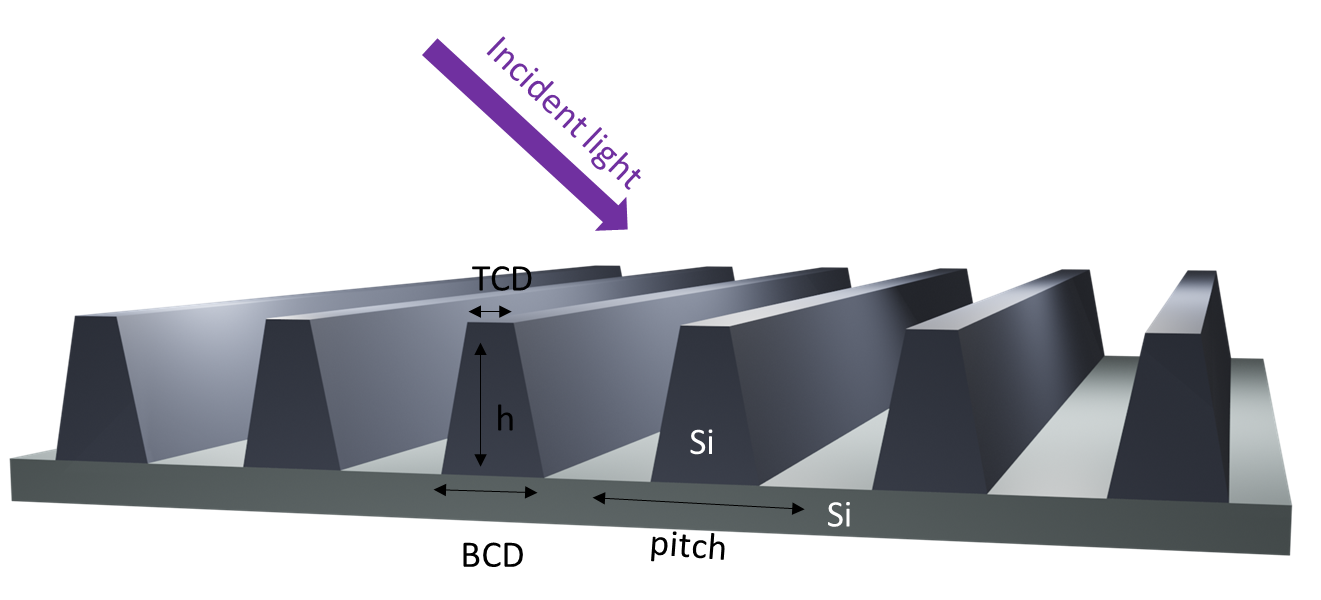

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import sys
path_parent=os.path.dirname(os.getcwd())
sys.path.insert(0,path_parent)

from src import ReadData
from src import rcwa
from src import Mueller
from matplotlib.offsetbox import AnchoredText

path_image=path_parent +"/image/Si_grating_MM.png"
from IPython.display import Image
Image(filename=path_image,width=250)

## 1. Optical index: 

Make sure that eps have negative sign: eps=eps1-1j*eps2

In [2]:
# 1. read optical index from database
path_optical_index=path_parent+'/dataNK/'
path_Si=path_optical_index+ 'c-Si_HJY_Modif.txt'

h=4.135667516*1e-15;#[eV s]      
c=299792458         #[m/s]

Si_wl, Si_nk=ReadData.read_nk(path_Si)
Si_wl=h*c/Si_wl*10**9      #eV to nm

# 2.Interpolate
wavelength_range=np.linspace(450,825,50) 
e_Si=ReadData.interpolate(wavelength_range,[Si_wl, Si_nk])
#reflectance and transmittance zone
e_trn=np.copy(e_Si);  
e_ref=1 # air

## 2. Input parameters

For 2D simulations, the periodic length `Ly`, the simulation domain `Ny`, and the diffraction order in the y-direction are set to `float("inf")`, `1`, and `0`, respectively.

In [3]:
sim=rcwa()
sim.setup(wavelength_range=wavelength_range,
        LxLy=[1100,float("Inf")],    # periodic length [Lx,Ly]
        NxNy=[1100,1],               # simulation domain [Nx,Ny]
        order=[15,0],                # diffraction order [mx,my]                   
        e_ref=e_ref,                 # reflected medium
        e_trn=e_trn,                 # transmitted medium                   
            )

## 3. Geometry: user define

In [4]:
layer=sim.Geometry.layer()  
mask=sim.Geometry.Rectangle(Wx=250) 
layer['medium']={'eps':1,'h':100,'eps_name':'air'}
layer['pattern']={'eps':e_Si, 'mask':mask,'eps_name':'Si'}   
    
Structure=[layer]  

C:\Users\hpham\Desktop\RCWA_numpy\src\Geometry.py:13: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


## 4. Visualization

In [5]:
sim.Plot.XY(Structure,layer_position=[0])

XY view is not available for 2D structures


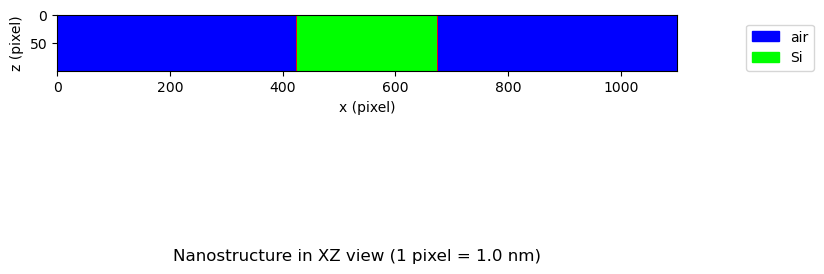

In [6]:
sim.Plot.XZ(Structure)

##  5. Simulation

### 5.1 Conventional

In [7]:
t0=time.time()

AOI_d=45
Azimuth_d_range=[0,15,30,45,60,75,90]
#Azimuth_d_range=[0]
MM=[]
for Azimuth_d in Azimuth_d_range:
    Coeff=[]
    for wth in range(len(wavelength_range)): 
    
        #Scattering matrix    
        S_layer=sim.S_layer(Structure,idx=wth,angle=[AOI_d,Azimuth_d])    
        S_global=sim.S_System(S_layer,S_Ref=False)    
    
        # coefficients
        S_global_11=S_global[0];   
        order =sim.Nharm//2
    
        sim.SourcePlaneWave(mode='TE')
        rxS,ryS= sim.coeff(S_global_11)  
    
        sim.SourcePlaneWave(mode='TM')
        rxP,ryP= sim.coeff(S_global_11)  

        Coeff.append([rxP[order],ryP[order],rxS[order],ryS[order]])

    Coeff=np.stack(Coeff)   
    Coeff=Coeff.transpose(1,0)    # shape: 4 x wl     
    rpp,rps,rsp,rss=sim.Rotate_SP(Coeff) #rotate AOI, azimuth

   # Muller matrix
    m11,m12,m13,m14,m22,m23,m24,m33,m34,m44=Mueller.matrix(rpp,rps,rsp,rss)  # 9 mm
    MM_a=np.stack([m12/m11,m13/m11,m14/m11,m22/m11,m23/m11,m24/m11,m33/m11,m34/m11,m44/m11])
    MM_a=Mueller.MM9_to_MM16(MM_a)  # thanks to the symmetry of MM, we can calculate 16 mm from 9 mm
    MM_a=MM_a.reshape(4,4,len(wavelength_range)) # 4 x 4 x wl

    MM.append(MM_a)  
MM=np.stack(MM)
#print(time.time() -t0)    

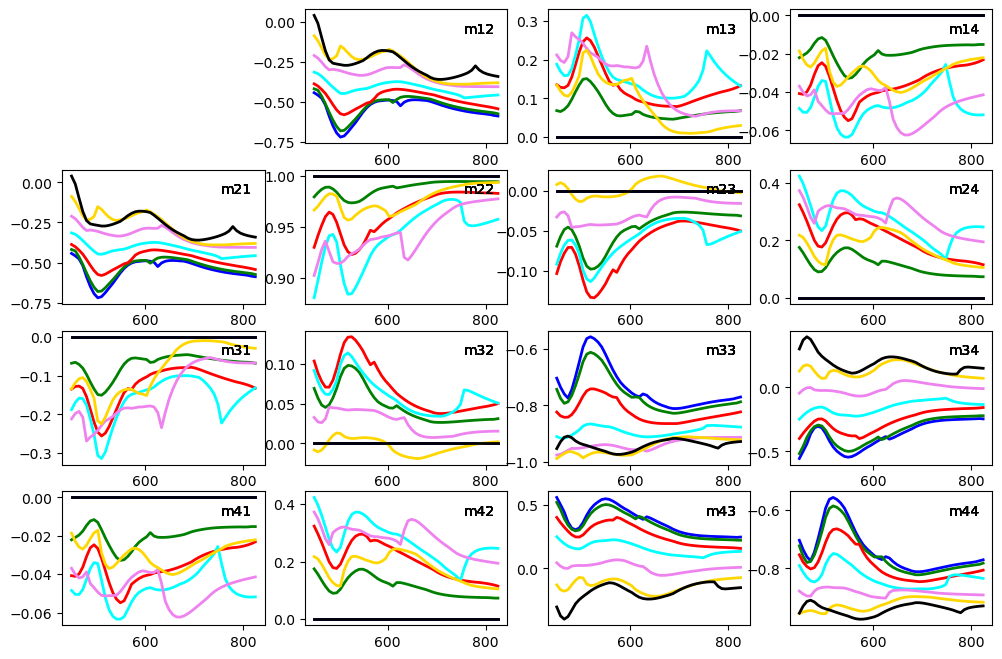

In [8]:
plt.figure(figsize=(12,8))
color=['blue','green','red','cyan','violet','gold','black']

MM=MM.swapaxes(1,2)
for i in range(4):
    for j in range(4):
        ax = plt.subplot2grid((4,4), (i,j))
        if i==0 and j==0: ax.remove() 
        for idx in range(len(Azimuth_d_range)):               
                            
            ax.plot(wavelength_range,MM[idx][i,j],lw=2,c=color[idx])            
            anchored_text = AnchoredText("m" + str(i+1) +str(j+1), loc=1,frameon=False)           
            ax.add_artist(anchored_text)
            
ax = plt.subplot2grid((4,4), (0,0))
ax.plot(wavelength_range,MM[0][0,0],lw=2,c='white')
ax.axis('off')
anchored_text = AnchoredText("", loc=1,frameon=False)
ax.add_artist(anchored_text)
    
plt.show()

###  5.3 Bottom-up: 

The bottom-up approach is developed for multilayer structures with bottom homogeneous layers. However, the bottom-up approach can also be used to enhance the numerical efficiency of one-layer structures. 


In [9]:
t0=time.time()

AOI_d=45
Azimuth_d_range=[0,15,30,45,60,75,90]
#Azimuth_d_range=[0]
MM=[]
for Azimuth_d in Azimuth_d_range:
    Coeff=[]
    for wth in range(len(wavelength_range)): 
    
        #Scattering matrix    
        S_layer=sim.S_layer(Structure,idx=wth,angle=[AOI_d,Azimuth_d])    
        S_global_11,S_global_21=sim.S_System_bottom_up(S_layer,S_Ref=False)   
    
        # coefficients          
        order =sim.Nharm//2
    
        sim.SourcePlaneWave(mode='TE')
        rxS,ryS= sim.coeff(S_global_11)  
    
        sim.SourcePlaneWave(mode='TM')
        rxP,ryP= sim.coeff(S_global_11)  

        Coeff.append([rxP[order],ryP[order],rxS[order],ryS[order]])

    Coeff=np.stack(Coeff)   
    Coeff=Coeff.transpose(1,0)    # shape: 4 x wl     
    rpp,rps,rsp,rss=sim.Rotate_SP(Coeff) #rotate AOI, azimuth

   # Muller matrix
    m11,m12,m13,m14,m22,m23,m24,m33,m34,m44=Mueller.matrix(rpp,rps,rsp,rss)  # 9 mm
    MM_a=np.stack([m12/m11,m13/m11,m14/m11,m22/m11,m23/m11,m24/m11,m33/m11,m34/m11,m44/m11])
    MM_a=Mueller.MM9_to_MM16(MM_a)  # thanks to the symmetry of MM, we can calculate 16 mm from 9 mm
    MM_a=MM_a.reshape(4,4,len(wavelength_range)) # 4 x 4 x wl

    MM.append(MM_a)  
MM=np.stack(MM)
#print(time.time() -t0)    

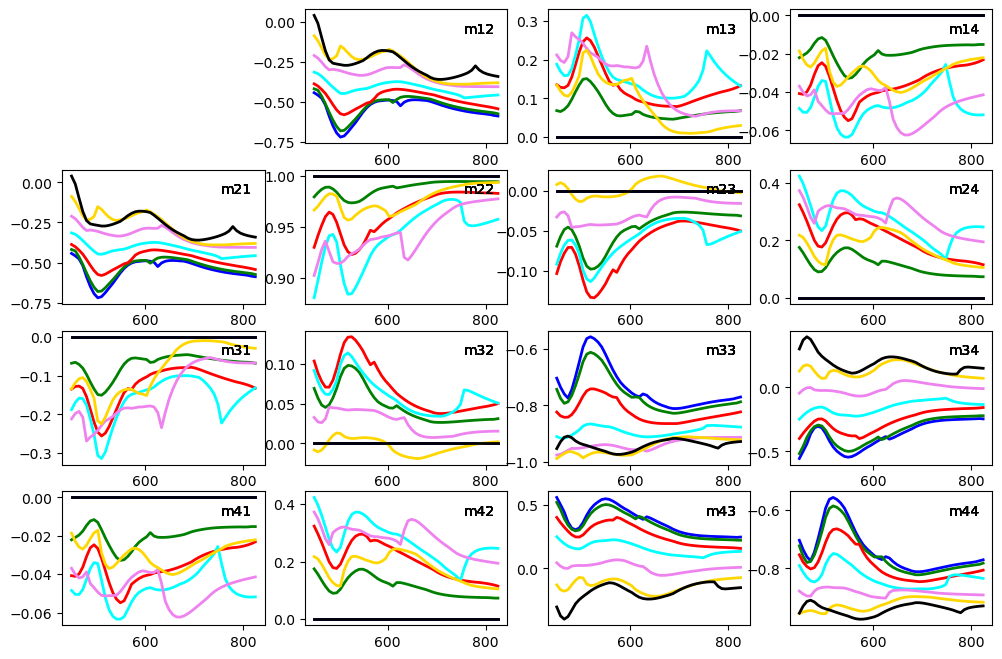

In [10]:
plt.figure(figsize=(12,8))
color=['blue','green','red','cyan','violet','gold','black']

MM=MM.swapaxes(1,2)
for i in range(4):
    for j in range(4):
        ax = plt.subplot2grid((4,4), (i,j))
        if i==0 and j==0: ax.remove() 
        for idx in range(len(Azimuth_d_range)):               
                            
            ax.plot(wavelength_range,MM[idx][i,j],lw=2,c=color[idx])            
            anchored_text = AnchoredText("m" + str(i+1) +str(j+1), loc=1,frameon=False)           
            ax.add_artist(anchored_text)
            
ax = plt.subplot2grid((4,4), (0,0))
ax.plot(wavelength_range,MM[0][0,0],lw=2,c='white')
ax.axis('off')
anchored_text = AnchoredText("", loc=1,frameon=False)
ax.add_artist(anchored_text)
    
plt.show()